<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Problem-1" data-toc-modified-id="Problem-1-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Problem 1</a></span></li></ul></div>

# Problem 1

In the cell below, write a script that:

1. Reads Modis channel 30 (ozone absorbing channel) and Modis Channel 31 (one of the "window" channels) into two numpy arrays (see [Modis channel listing](https://modis.gsfc.nasa.gov/about/specifications.php))

1. Converts them to calibrated radiances using the mid-range wavelength for each channel

1. Calculates the brightness temperature for each channel using the code in the a301.radiation module

1. plots the brightness temperature difference Tbright31 - Tbright30 for your scene

In [1]:
from pathlib import Path 
from pyhdf.SD import SD, SDC 
import numpy as np
from matplotlib import pyplot as plt

In [2]:
home = Path.home()
print(home)
data_dir = home / Path("Desktop/ubc/a301")
print(data_dir)

C:\Users\mu448
C:\Users\mu448\Desktop\ubc\a301


In [3]:
hdf_files = list(data_dir.glob("MYD021KM*2001*.hdf"))
hdf_files

[WindowsPath('C:/Users/mu448/Desktop/ubc/a301/MYD021KM.A2012001.1815.061.2018036205336.hdf'),
 WindowsPath('C:/Users/mu448/Desktop/ubc/a301/MYD021KM.A2012001.1950.061.2018036204921.hdf'),
 WindowsPath('C:/Users/mu448/Desktop/ubc/a301/MYD021KM.A2012001.2130.061.2018036204846.hdf'),
 WindowsPath('C:/Users/mu448/Desktop/ubc/a301/MYD021KM.A2012001.2310.061.2018036205311.hdf')]

In [4]:
file_name = str(data_dir / Path(hdf_files[0]))
print(f'reading {file_name}')
the_file = SD(file_name, SDC.READ)
stars='*'*50
print((f'\n{stars}\nnumber of datasets, number of attributes'
       f'={the_file.info()}\n{stars}\n'))

reading C:\Users\mu448\Desktop\ubc\a301\MYD021KM.A2012001.1815.061.2018036205336.hdf

**************************************************
number of datasets, number of attributes=(31, 58)
**************************************************



In [5]:
datasets_dict = the_file.datasets()

In [6]:
longwave_data = the_file.select('EV_1KM_Emissive')
print(longwave_data.info())

('EV_1KM_Emissive', 3, [16, 2030, 1354], 23, 8)


In [7]:
longwave_bands = the_file.select('Band_1KM_Emissive')
band_nums=longwave_bands.get()

In [8]:
ch31_index=np.searchsorted(band_nums,31.)
ch31_index = int(ch31_index)
ch31_data = longwave_data[ch31_index,:,:]

In [9]:
scales=longwave_data.attributes()['radiance_scales']
offsets=longwave_data.attributes()['radiance_offsets']
ch31_scale=scales[ch31_index]
ch31_offset=offsets[ch31_index]
print(f'scale: {ch31_scale}, offset: {ch31_offset}')

scale: 0.0006508072256110609, offset: 2035.9332275390625


In [10]:
ch31_calibrated =(ch31_data - ch31_offset)*ch31_scale    # convert channel 31 to calibrated radiances 

In [11]:
outname="ch31_out.hdf"      # creat a hdf file for channel 31
sd = SD(outname, SDC.WRITE | SDC.CREATE)
sds = sd.create("ch31", SDC.FLOAT64, ch31_calibrated.shape)
sds.setfillvalue(0)
dim1 = sds.dim(0)
dim1.setname("row")
dim2 = sds.dim(1)
dim2.setname("col")
sds.units = "W/m^2/micron/sr"
sds[:,:] = ch31_calibrated
sds.endaccess()
sd.end()

In [12]:
local_file = Path.cwd() / Path(outname)
to_file = data_dir / Path(outname)
local_file.rename(to_file)

In [13]:
hdf_files=list(data_dir.glob("ch30_out*.hdf"))     #read channel 30 and 31 data 
hdf_files

[WindowsPath('C:/Users/mu448/Desktop/ubc/a301/ch30_out.hdf')]

In [14]:
file_name = str(data_dir / Path(hdf_files[0]))
the_file = SD(file_name, SDC.READ)
stars='*'*50
datasets_dict = the_file.datasets()

for idx,sds in enumerate(datasets_dict.keys()):
    print(idx,sds)

0 ch30


In [15]:
ch30_data = the_file.select('ch30').get() 

In [16]:
hdf_files=list(data_dir.glob("ch31_out*.hdf"))
hdf_files

[WindowsPath('C:/Users/mu448/Desktop/ubc/a301/ch31_out.hdf')]

In [17]:
file_name = str(data_dir / Path(hdf_files[0]))
the_file = SD(file_name, SDC.READ)
stars='*'*50
datasets_dict = the_file.datasets()

for idx,sds in enumerate(datasets_dict.keys()):
    print(idx,sds)

0 ch31


In [18]:
ch31_data = the_file.select('ch31').get() 

In [21]:
from radiance import planck_invert
wavel_30= 9.73e-6  
wavel_31= 11.03e-6  #wavelength in meters
ch30_radiances=ch30_data*1.e6;
ch31_radiances=ch31_data*1.e6;   #convert radiance to MKS
ch30_Tbright = planck_invert(wavel_30,ch30_radiances)
ch31_Tbright = planck_invert(wavel_31,ch31_radiances)
T_difference = ch31_Tbright - ch30_Tbright

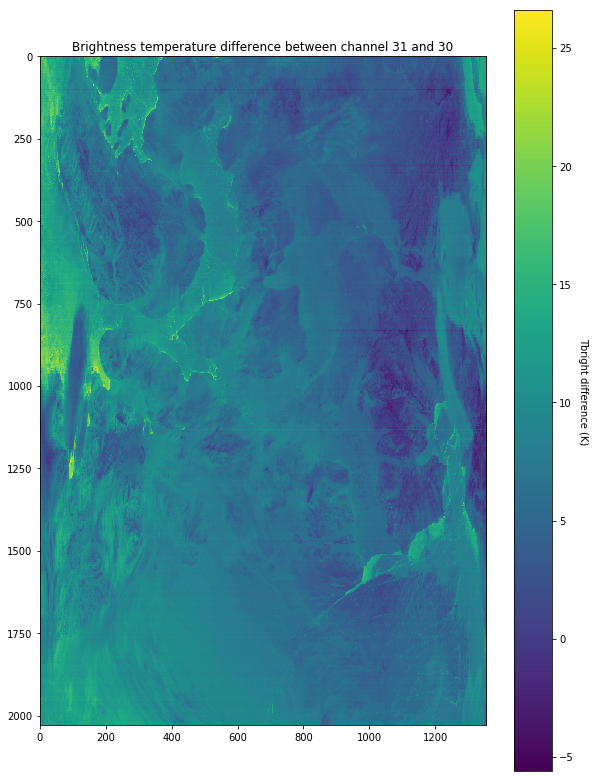

In [22]:
%matplotlib inline
from matplotlib import pyplot as plt
fig,ax = plt.subplots(1,1,figsize = (10,14))
CS=ax.imshow(T_difference)
cax=fig.colorbar(CS)
ax.set_title('Brightness temperature difference between channel 31 and 30')
out=cax.ax.set_ylabel('Tbright difference (K)')
out.set_verticalalignment('bottom')
out.set_rotation(270)